In [1022]:
#Import the packages needed to work with this dataset (i.e. visualization, calculations, modeling)

import numpy as np
import calendar
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

# I. DATA CLEANING

In [1023]:
df = pd.read_csv('kc_house_data.csv') #import the original/master dataset

In [1024]:
df.head() #preview the data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [1025]:
df.info() #inspect the data (i.e. data types, size, # of columns, etc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


## REMOVING NULL VALUES

In [1026]:
df.isna().sum() #check to see if the data has null (NaN) values

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### NOTE:
_It looks like we have 3 columns that contain null values. As a first step, it makes sense to remove every row containing null values from the **'view'** column since only 63 out of 21K values are null (therefore we will not be significantly changing the data by dropping these values)._

In [1027]:
df.dropna(subset=['view'], inplace=True) #drop the rows containing null values from the 'view' column
df.isna().sum() #check to see if the change was successful

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2370
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3830
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### NOTE:
_Great, so dropping the null values from the 'view' column worked. Let's check out the 'waterfront' column now._

In [1028]:
df['waterfront'].value_counts() #examine the different values in the 'waterfront' column

0.0    19019
1.0      145
Name: waterfront, dtype: int64

#### NOTE:
_As expected, the data in this column does not indicate which waterfront (i.e. Caribbean Sea) a house is near. Instead, it simply provides a '0' if the house is not situated on a waterfront and a '1' if it is._

_Since waterfronts seem to be quite rare, we can reasonably fill the null values with a '0' without distorting the dataset too much. Let's try it._

In [1029]:
df['waterfront'] = df['waterfront'].fillna(0) #fill the null values in this column with a '0'

In [1030]:
df.isna().sum() #check to see if the change was successful

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3830
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

#### NOTE:
_The 'yr__renovated' column seems to be the last one containing null values. Let's take a closer look at it._

In [1031]:
df['yr_renovated'].value_counts() #examine the different values in the 'yr_renovated' column

0.0       16961
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

#### NOTE:
_Similar to the previous column, the overwhelming majority of the houses seem to never have been renovated. We can the 'ffill' method to fill the null values in this column with whatever the preceding value is (which was almost always be 0 and therefore not distort our dataset)._

In [1032]:
df['yr_renovated'] = df['yr_renovated'].fillna(method='ffill') #fill null values with the values preceding them

In [1033]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

#### NOTE:
_Success! We no longer have null values in our dataset._

## REFINEMENT

In [1034]:
df.head() #preview the data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,1991.0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


#### NOTE:
_A good way to refine data for one's use case is to remove data that is either 1) superfluous/repetitive or 2) not relevant to the problem at hand - it looks like we have some of both._

In [1035]:
df = df.drop(columns=['sqft_living15', 'sqft_lot15', 'sqft_living', 'sqft_above', 'zipcode', 'lat', 'long', 'id'])
#drop the columns that do not have to do with inside space or are repetitive

In [1036]:
df.head() #check to see if the change was successful

,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated
0,10/13/2014,221900.0,3,1.00,5650,1.0,0.0,0.0,3,7,0.0,1955,0.0
1,12/9/2014,538000.0,3,2.25,7242,2.0,0.0,0.0,3,7,400.0,1951,1991.0
2,2/25/2015,180000.0,2,1.00,10000,1.0,0.0,0.0,3,6,0.0,1933,1991.0
3,12/9/2014,604000.0,4,3.00,5000,1.0,0.0,0.0,5,7,910.0,1965,0.0
4,2/18/2015,510000.0,3,2.00,8080,1.0,0.0,0.0,3,8,0.0,1987,0.0


## DATA TYPES

In [1037]:
df.info() #take a closer look at the data types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 13 columns):
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
yr_renovated     21534 non-null float64
dtypes: float64(6), int64(5), object(2)
memory usage: 2.3+ MB


#### NOTE:
_Most of our columns seem to check out with 'float' or 'integer' data types (which will help us in the data exploration and modeling stages), but the 'date' and 'sqft__basement' columns seem to be labeled as 'object' data types. This means that our dataset is not treating the values in these columns as numerical (which will definitely pose problems down the road unless we fix it)._

_Let's take a look at the 'date' column first where the date contains numbers that are separated by a '/'. We can fix this by removing the '/' and separating these values into their own separate columns._

In [1038]:
df[['month','day','year']] = df.date.str.split('/',expand=True)

#use the split method to split data according to the parameter that you set (i.e. '/')

In [1039]:
df.head() #check to see if it worked

,date,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,month,day,year
0,10/13/2014,221900.0,3,1.00,5650,1.0,0.0,0.0,3,7,0.0,1955,0.0,10,13,2014
1,12/9/2014,538000.0,3,2.25,7242,2.0,0.0,0.0,3,7,400.0,1951,1991.0,12,9,2014
2,2/25/2015,180000.0,2,1.00,10000,1.0,0.0,0.0,3,6,0.0,1933,1991.0,2,25,2015
3,12/9/2014,604000.0,4,3.00,5000,1.0,0.0,0.0,5,7,910.0,1965,0.0,12,9,2014
4,2/18/2015,510000.0,3,2.00,8080,1.0,0.0,0.0,3,8,0.0,1987,0.0,2,18,2015


In [1040]:
df = df.drop(columns=['day', 'date']) #drop the old 'date' column and the new 'day' column

In [1041]:
df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,month,year
0,221900.0,3,1.00,5650,1.0,0.0,0.0,3,7,0.0,1955,0.0,10,2014
1,538000.0,3,2.25,7242,2.0,0.0,0.0,3,7,400.0,1951,1991.0,12,2014
2,180000.0,2,1.00,10000,1.0,0.0,0.0,3,6,0.0,1933,1991.0,2,2015
3,604000.0,4,3.00,5000,1.0,0.0,0.0,5,7,910.0,1965,0.0,12,2014
4,510000.0,3,2.00,8080,1.0,0.0,0.0,3,8,0.0,1987,0.0,2,2015


In [1042]:
df.info() #check to see if it worked

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 14 columns):
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
yr_renovated     21534 non-null float64
month            21534 non-null object
year             21534 non-null object
dtypes: float64(6), int64(5), object(3)
memory usage: 2.5+ MB


#### NOTE:
_Whoops, we still seem to have 'object' data types in our data :(_

_We will need to convert our 'month' and 'year' columns to 'integer' data types if we plan on using them later on._

In [1043]:
df['month'] = df.month.astype(int) #convert the datatype to 'integer' using astype
df['year'] = df.year.astype(int) #convert the datatype to 'integer' using astype

In [1044]:
df.info() #check to see if it worked

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 14 columns):
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
yr_renovated     21534 non-null float64
month            21534 non-null int64
year             21534 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 2.5+ MB


#### NOTE:
_It worked but we still need to fix the 'sqft__basement' column. Something must be off since one would not intuit that square feet should be numeric and not an object._

In [1045]:
df['sqft_basement'].head(n=20) #look at the first 20 rows in the column

0        0.0
1      400.0
2        0.0
3      910.0
4        0.0
5     1530.0
6          ?
8      730.0
9        0.0
10    1700.0
11     300.0
12       0.0
13       0.0
14       0.0
15     970.0
16       0.0
17       0.0
18         ?
19       0.0
20     760.0
Name: sqft_basement, dtype: object

#### NOTE:
_Our suspicions were correct...there are question marks in our data for some reason. Something we can do is replace every '?' with a null value to make it a little easier to work with._

In [1046]:
df['sqft_basement'] = df['sqft_basement'].replace('?', np.nan) #replace '?' with NaN

In [1047]:
df['sqft_basement'].head(n=20) #check to see if it worked

0        0.0
1      400.0
2        0.0
3      910.0
4        0.0
5     1530.0
6        NaN
8      730.0
9        0.0
10    1700.0
11     300.0
12       0.0
13       0.0
14       0.0
15     970.0
16       0.0
17       0.0
18       NaN
19       0.0
20     760.0
Name: sqft_basement, dtype: object

In [1048]:
df['sqft_basement'] = pd.to_numeric(df.sqft_basement, errors="coerce") #convert the data to a numerical type
df['sqft_basement'] #check to see if it worked

0          0.0
1        400.0
2          0.0
3        910.0
4          0.0
         ...  
21592      0.0
21593      0.0
21594      0.0
21595      0.0
21596      0.0
Name: sqft_basement, Length: 21534, dtype: float64

#### NOTE:
_The last step is to address the remaining null values in the 'sqft__basement' column. Something we can do is replace the null values with a '0' since the impact of this change is likely to be miniscule._

In [1049]:
df['sqft_basement'].isna().sum() #count the remaining null values

452

In [1050]:
df['sqft_basement'] = df.sqft_basement.fillna(0) #fill the null values with a '0'

In [1051]:
df['sqft_basement'].isna().sum() #check to see if it worked

0

#### NOTE:
_Success! We have not managed null values, removed non-essential columns, and corrected data types in our data set._

_Next, we will try to make our data set even leaner by converting non-categorical data into categorical data where helpful. For instance, the price difference between a basement with 500 square feet vs. a similar basement with 525 square feet is very likely to be neglible; however, a house with a basement versus one without a basement will likely present a tangible difference in terms of pricing so it would make sense to convert this column into categorical data._

## CONVERTING TO CATEGORICAL

In [1052]:
df['basement'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
#use a lambda function to convert the data into categorical data

df['basement'] #check if it worked

0        0
1        1
2        0
3        1
4        0
        ..
21592    0
21593    0
21594    0
21595    0
21596    0
Name: basement, Length: 21534, dtype: int64

In [1053]:
df = df.drop(columns=['sqft_basement']) #drop the non-categorical column

In [1054]:
df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
#use a lambda function to convert the data into categorical data

df['renovated'] #check if it worked

0        0
1        1
2        1
3        0
4        0
        ..
21592    0
21593    0
21594    0
21595    0
21596    0
Name: renovated, Length: 21534, dtype: int64

In [1055]:
df = df.drop(columns=['yr_renovated']) #drop the non-categorical column

#### NOTE:
_Now that we have converted some of our data into categorical data, we can take a final shot at cleaning our data by checking for outlier values that might throw off our analysis later on._

## REMOVING OUTLIERS

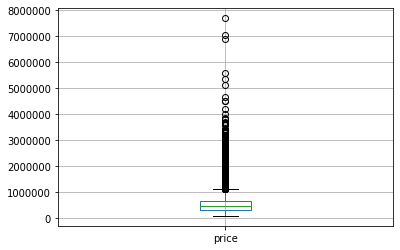

In [1056]:
df.boxplot(['price']) #visualize the distribution of the column

#### NOTE:
_Although there is space between the values in the 'price' column, there is no major outlier that would call for removal. Let's move on._

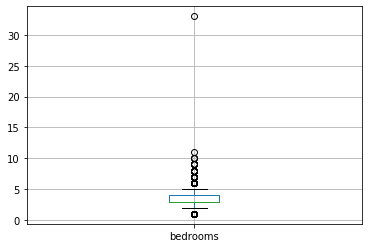

In [1057]:
df.boxplot(['bedrooms']) #visualize the distribution of the column

In [1058]:
print(df['bedrooms'].min()) #get a sense of the column's minimum value
print(df['bedrooms'].max()) #get a sense of the column's maximum value

1
33


#### NOTE:
_The 'bedrooms' column definitely seems to have a major outlier so let's remove it._

In [1059]:
df.drop(df[df['bedrooms'] == 33].index, axis=0, inplace=True) #remove the value and apply it permanently

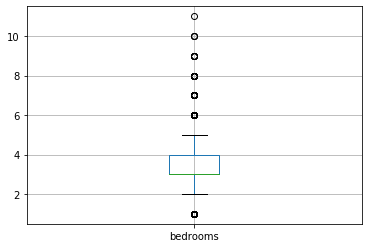

In [1060]:
df.boxplot(['bedrooms']) #visualize the distribution of the column

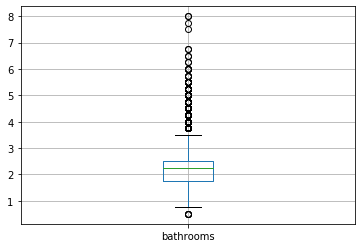

In [1061]:
df[['bathrooms']].boxplot() #visualize the distribution of the column

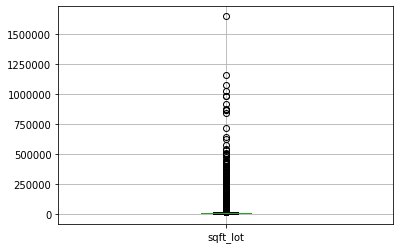

In [1062]:
df[['sqft_lot']].boxplot() #visualize the distribution of the column

In [1063]:
print(df['sqft_lot'].min()) #get a sense of the column's minimum value
print(df['sqft_lot'].max()) #get a sense of the column's maximum value

520
1651359


In [1064]:
df.drop(df[df['sqft_lot'] == 1651359].index, axis=0, inplace=True) #remove the value and apply it permanently

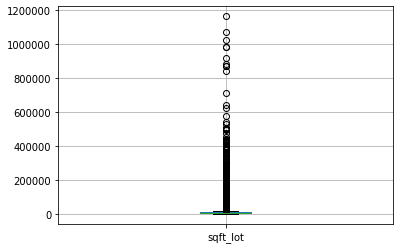

In [1065]:
df[['sqft_lot']].boxplot() #visualize the distribution of the column

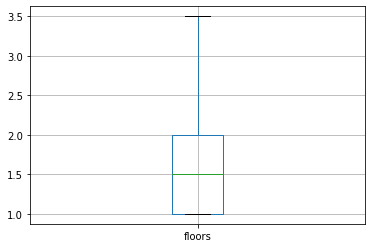

In [1066]:
df[['floors']].boxplot() #visualize the distribution of the column

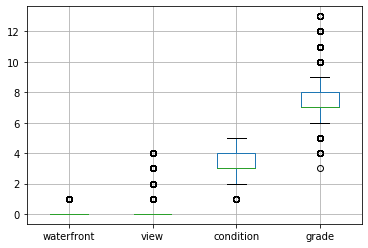

In [1067]:
df[['waterfront', 'view', 'condition', 'grade']].boxplot() #visualize the distribution of the column

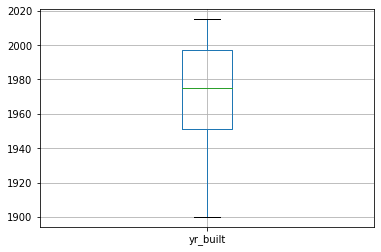

In [1068]:
df[['yr_built']].boxplot() #visualize the distribution of the column

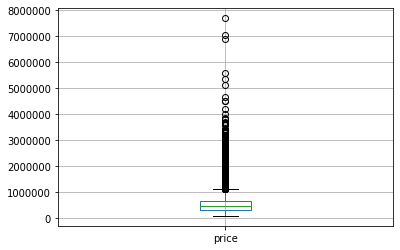

In [1069]:
df[['price']].boxplot() #visualize the distribution of the column

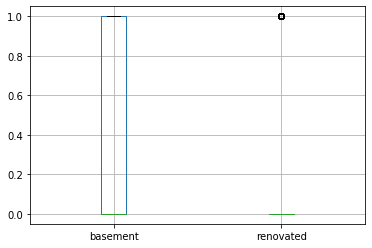

In [1070]:
df[['basement', 'renovated']].boxplot() #visualize the distribution of the column

#### NOTE:
_All of our outliers are removed, so we should be done with data cleaning now!_

# II. DATA EXPLORATION & ANALYSIS

#### NOTE:
_Regression analyses seek to isolate the relationships between independent and dependent variables. Therefore, it is important to check for multicollinearity which is defined as a high correlation between two or more predictor variables. Below we will test for multicollinearity and define any 2 variables with a correlation coefficient above 0.75 as being "multicollinear" and therefore having to be removed from the dataset._

_More on multicollinearity can be found here:
https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/#:~:text=Multicollinearity%20occurs%20when%20independent%20variables,model%20and%20interpret%20the%20results_

## MULTICOLLINEARITY

In [1071]:
df.corr() #examine the correlation betweem the variables in our dataset

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,yr_built,month,year,basement,renovated
price,1.000000,0.315226,0.525120,0.092979,0.257094,0.259224,0.395788,0.035349,0.668383,0.054324,-0.009666,0.003528,0.177584,0.113934
bedrooms,0.315226,1.000000,0.527842,0.033852,0.183192,-0.003697,0.080831,0.023308,0.365789,0.160607,-0.000580,-0.009339,0.160031,0.017835
bathrooms,0.525120,0.527842,1.000000,0.095105,0.502249,0.061111,0.186755,-0.126594,0.665276,0.507501,0.007053,-0.026061,0.159814,0.044484
sqft_lot,0.092979,0.033852,0.095105,1.000000,-0.003482,0.022445,0.071320,-0.010403,0.122241,0.057976,-0.001450,0.003654,-0.034730,0.010974
floors,0.257094,0.183192,0.502249,-0.003482,1.000000,0.020351,0.028587,-0.264048,0.458652,0.489363,0.013726,-0.021999,-0.252569,0.003977
waterfront,0.259224,-0.003697,0.061111,0.022445,0.020351,1.000000,0.382129,0.016239,0.081192,-0.025012,0.008666,-0.005793,0.038775,0.081802
view,0.395788,0.080831,0.186755,0.071320,0.028587,0.382129,1.000000,0.045639,0.250045,-0.054306,-0.005139,0.001251,0.177692,0.091151
condition,0.035349,0.023308,-0.126594,-0.010403,-0.264048,0.016239,0.045639,1.000000,-0.147234,-0.361320,0.022420,-0.045942,0.129871,-0.046858
grade,0.668383,0.365789,0.665276,0.122241,0.458652,0.081192,0.250045,-0.147234,1.000000,0.448182,0.008708,-0.030042,0.049956,0.018146
yr_built,0.054324,0.160607,0.507501,0.057976,0.489363,-0.025012,-0.054306,-0.361320,0.448182,1.000000,-0.006735,0.003781,-0.163773,-0.187050


In [1072]:
abs(df.corr()) > 0.75 #return true or false for correlation variables above 0.75

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,yr_built,month,year,basement,renovated
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,True,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,True,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,True,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,False,False,False,False
yr_built,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [1073]:
df1 = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
#determine the output of the correlation check

df1['pairs'] = list(zip(df1.level_0, df1.level_1))
#create a list of tuples

df1.set_index(['pairs'], inplace = True)
#set the new 'pairs' column as the index

df1.drop(columns=['level_1', 'level_0'], inplace = True)
#drop columns

df1.columns = ['cc']
#cc for correlation coefficient

df1.drop_duplicates(inplace=True)
#drop duplicates

df1[(df1.cc>.75) & (df1.cc<1)]
#display pairs and their coefficients

,cc
pairs,
"(month, year)",0.782088


In [1074]:
df = df.drop(columns=['year']) #drop the column causing multicollinearity

#### NOTE:
_Drop the 'year' column because it is not as specific as the 'month' column and we have to remove one or the other because of multicollinearity._

In [1075]:
df.head() #look at the new dataset

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,yr_built,month,basement,renovated
0,221900.0,3,1.00,5650,1.0,0.0,0.0,3,7,1955,10,0,0
1,538000.0,3,2.25,7242,2.0,0.0,0.0,3,7,1951,12,1,1
2,180000.0,2,1.00,10000,1.0,0.0,0.0,3,6,1933,2,0,1
3,604000.0,4,3.00,5000,1.0,0.0,0.0,5,7,1965,12,1,0
4,510000.0,3,2.00,8080,1.0,0.0,0.0,3,8,1987,2,0,0


## VISUALIZATION #1: BASEMENT

#### NOTE:
_Let's visualize parts of our dataset to take a closer look at certain variables and their relationships with the rest of the data. We can start with the 'basement' column given our problem statement of determining how different spaces inside of the house affect the sale price._

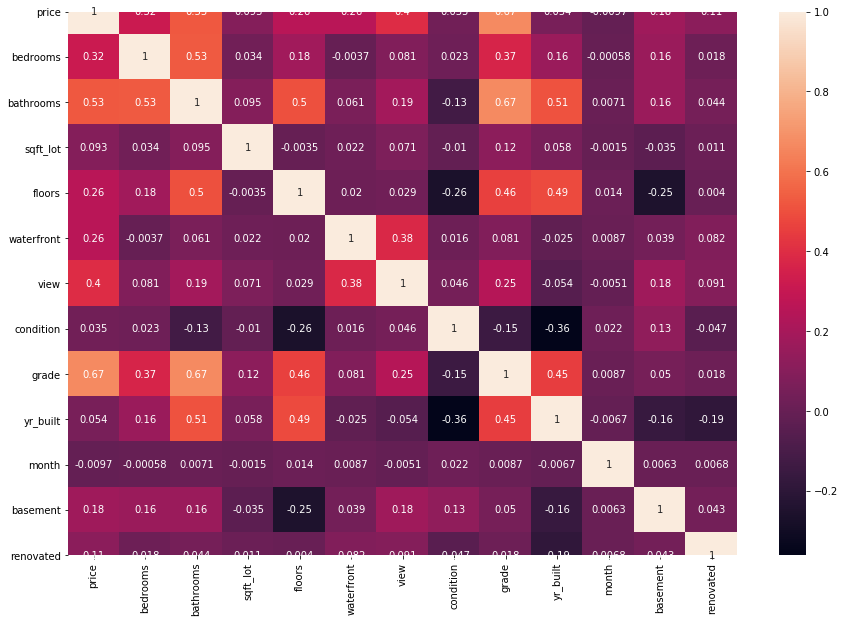

In [1076]:
plt.figure(figsize=(15, 10)) #set the size of the visualization
sns.heatmap(df.corr(), annot=True) #plot a heatmap of the correlations

In [1077]:
df = df.sort_values(by=['price'], ascending=False) 

In [1078]:
df.head(n=20)

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,yr_built,month,basement,renovated
7245,7700000.0,6,8.00,27600,2.5,0.0,3.0,4,13,1910,10,1,1
3910,7060000.0,5,4.50,37325,2.0,1.0,2.0,3,11,1940,6,1,1
9245,6890000.0,6,7.75,31374,2.0,0.0,4.0,3,13,2001,9,1,0
4407,5570000.0,5,5.75,35069,2.0,0.0,0.0,3,13,2001,8,1,1
1446,5350000.0,5,5.00,23985,2.0,0.0,4.0,3,12,2009,4,1,0
1162,5110000.0,5,5.25,45517,2.0,1.0,4.0,3,12,1999,10,1,0
8085,4670000.0,5,6.75,13068,1.0,1.0,4.0,3,12,1983,6,1,1
2624,4500000.0,5,5.50,40014,2.0,1.0,4.0,3,12,2004,8,1,0
8629,4490000.0,4,3.00,27517,2.0,0.0,0.0,3,12,2001,6,0,0
12358,4210000.0,5,6.00,21540,2.0,0.0,0.0,3,12,2003,5,1,0


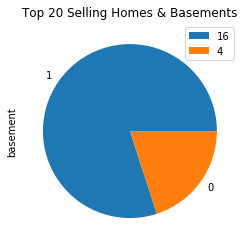

In [1079]:
df['basement'][0:20].value_counts().plot.pie()
plt.title('Top 20 Selling Homes & Basements')
plt.legend(df.basement[0:20].value_counts())

#### NOTE:
_As we can see above, there seems to be a slight correlation of 0.18 between 'price' and 'basement'._

## VISUALIZATION #2: TIMING / MONTH

#### NOTE:
_Since we are also analyzing the importance of timing, we can take visualize what affect 'month' has on variables like price or quantity of sales._

In [1080]:
df['month_name'] = df['month'].apply(lambda x: calendar.month_name[x])
#convert every month into its corresponding calendar month name

df['month_name'] #check to see if it worked

7245       October
3910          June
9245     September
4407        August
1446         April
           ...    
2139           May
8267      November
16184        March
465            May
15279          May
Name: month_name, Length: 21532, dtype: object

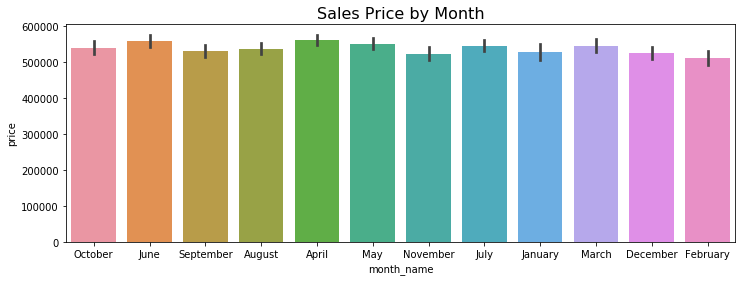

In [1081]:
months = df.month_name #assign a label
monthly_price = [] #set the for loop

for i in range(1,13):
    monthly_price.append(sum(df.price == i))
    
plt.figure(figsize=(12,4)) #size and parameters of the graph
sns.barplot(months, df.price) #type of graph and data
plt.title('Sales Price by Month', fontdict={'fontsize': 16}) #title and font size
plt.show() #visualize

#### NOTE:
_Although there generally seems to be consistency month-to-month in terms of how much houses sell for, our dataset shows that houses sell for the least in December and February (likely due to the holidays) and for the most in April-June (likely due to the start of summer)._

In [1082]:
df['month_name'].value_counts() #count the distribution across months for house sales

May          2408
April        2218
July         2210
June         2176
August       1933
October      1871
March        1866
September    1764
December     1464
November     1407
February     1243
January       972
Name: month_name, dtype: int64

Text(0.5, 1.0, '# of Sales by Month')

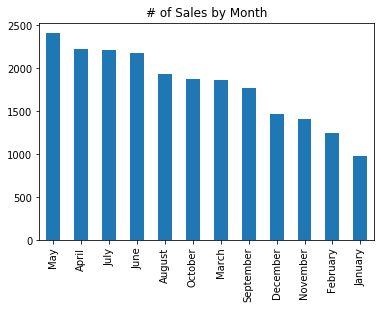

In [1083]:
df['month_name'].value_counts(sort=True).plot.bar() #visualize this distribution in the form of a bar graph
plt.title('# of Sales by Month')

#### NOTE:
_Interestingly enough, we can also see that the most houses sell during the months of May, April, and July (according to quantity of houses sold) which again affirms that the late Spring / early Summer months offer the highest likelihood of selling a home._

In [1084]:
df = df.drop(columns=['month_name']) #drop the 'month_name' column

## VISUALIZATION 3: SPACES

#### NOTE:
_Next, we can take a look at the correlation between sale price and ddifferent spaces inside of the house, starting with bedrooms._

Text(0.5, 1.0, 'Bedrooms vs. Mean Annual Price ($)')

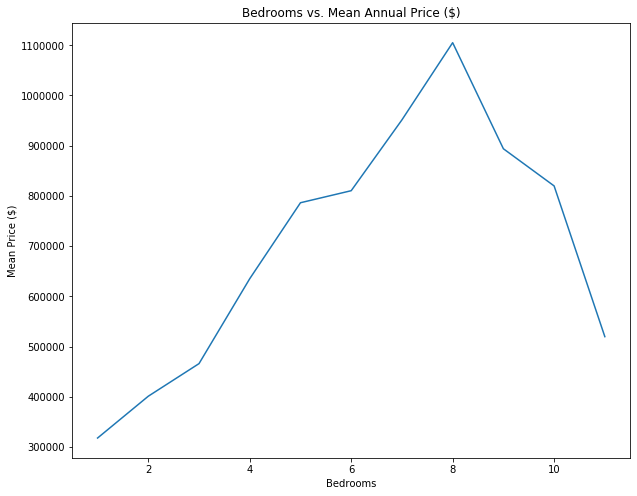

In [1085]:
plt.figure(figsize=(10, 8)) #dictate the figure size
plt.plot(df.groupby('bedrooms')['price'].mean()) #determine which columns to visualize
plt.xlabel('Bedrooms') #set the xlabel
plt.ylabel('Mean Price ($)') #set the ylabel
plt.title('Bedrooms vs. Mean Annual Price ($)') #name the graph

#### NOTE:
_As we can see, house prices rise as the number of bedrooms increase. However, in what seems to be a contradiction, we also notice that house prices decrease significantly with more than 8 bedrooms. This seems odd, so let's explore the data some more to take a look at what is behind this._

In [1086]:
df = df.sort_values(by=['bedrooms'], ascending=False) 

In [1087]:
df.head(n=20)

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,yr_built,month,basement,renovated
8748,520000.0,11,3.00,4960,2.0,0.0,0.0,3,7,1918,8,1,1
15147,650000.0,10,2.00,11914,2.0,0.0,0.0,4,7,1958,10,1,0
19239,660000.0,10,3.00,3745,2.0,0.0,0.0,4,7,1913,12,1,0
13301,1150000.0,10,5.25,10920,1.0,0.0,2.0,3,9,2008,8,1,0
4231,700000.0,9,3.00,4400,2.0,0.0,0.0,3,7,1908,1,1,0
4092,599999.0,9,4.50,6988,2.5,0.0,0.0,3,7,1938,5,1,0
16830,1400000.0,9,4.00,5508,2.5,0.0,0.0,3,11,1915,3,1,0
6073,1280000.0,9,4.50,5000,2.0,0.0,0.0,3,8,1915,8,1,1
18428,934000.0,9,3.00,4480,2.0,0.0,0.0,3,7,1918,3,1,0
8537,450000.0,9,7.50,6504,2.0,0.0,0.0,3,7,1996,8,0,0


#### NOTE:
_It seems that some of the homes with 9+ bedrooms are selling for lower prices because they 1) have less square footage, 2) are lower condition, and 3) are lower grade. Let's sort by 'price' to see if we spot any other trends._

In [1088]:
df = df.sort_values(by=['price'], ascending=False) 

In [1089]:
df[25:75]

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,yr_built,month,basement,renovated
20444,3350000.0,5,3.75,15360,1.0,0.0,1.0,3,11,2008,4,1,0
18288,3300000.0,5,6.25,21738,2.0,0.0,0.0,3,11,2001,7,0,0
18185,3300000.0,3,3.25,41300,1.0,1.0,4.0,4,11,1958,12,1,1
14070,3300000.0,5,4.75,13873,2.0,1.0,4.0,4,11,1989,9,1,0
18462,3300000.0,8,4.00,11750,3.5,0.0,0.0,5,12,1904,10,1,0
2442,3280000.0,2,1.75,10000,2.5,1.0,4.0,3,11,2001,12,1,0
15468,3200000.0,4,3.25,28206,1.0,1.0,4.0,4,12,1991,8,1,0
7900,3200000.0,6,5.00,18200,2.5,0.0,0.0,3,13,1933,9,1,1
20279,3200000.0,4,4.00,18851,2.0,0.0,3.0,3,11,2007,8,0,0
7184,3200000.0,7,4.50,8856,2.5,0.0,2.0,5,11,1910,5,1,0


#### NOTE:
_Here, we see affirmation of the pattern that we just pointed out, as the homes that sold for the highest amounts all have 1) high square footage (10K+) and 2) high grades (10+). This tells us that square footage and grade may be provide the highest correlation with house price so let's try to visualize it._

Text(0.5, 1.0, 'Grade vs. Mean Annual Price ($)')

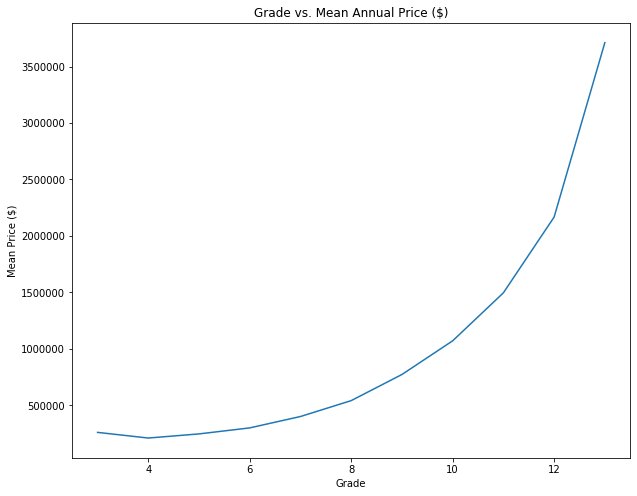

In [1090]:
plt.figure(figsize=(10, 8)) #dictate the figure size
plt.plot(df.groupby('grade')['price'].mean()) #determine which columns to visualize
plt.xlabel('Grade') #set the xlabel
plt.ylabel('Mean Price ($)') #set the ylabel
plt.title('Grade vs. Mean Annual Price ($)') #name the graph

#### NOTE:
_As suspected, there seems to be a very strong and linear relationship between the grade of a home and it's selling price. This makes sense since a high quality "turnkey" home should very much outweigh other, more peripheral factors like 'yr_built' or 'bathrooms'. With this being said, let's round out our analysis by examining the correlation between price and other spaces within the home._

Text(0.5, 1.0, 'Bathrooms vs. Mean Annual Price ($)')

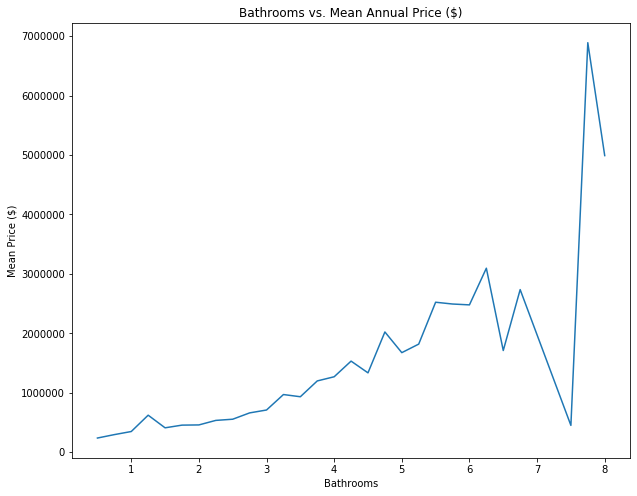

In [1091]:
plt.figure(figsize=(10, 8)) #dictate the figure size
plt.plot(df.groupby('bathrooms')['price'].mean()) #determine which columns to visualize
plt.xlabel('Bathrooms') #set the xlabel
plt.ylabel('Mean Price ($)') #set the ylabel
plt.title('Bathrooms vs. Mean Annual Price ($)') #name the graph

#### NOTE:
_The relationship between 'bathrooms' and 'price' also seems to be quite linear. One might even assume that a higher number of bathrooms is correlated to more square footage or the grade of a home._

_Our next and final step is to run our model!_

# III. MULTIPLE LINEAR REGRESSION MODEL

## FEATURE SCALING & NORMALIZATION

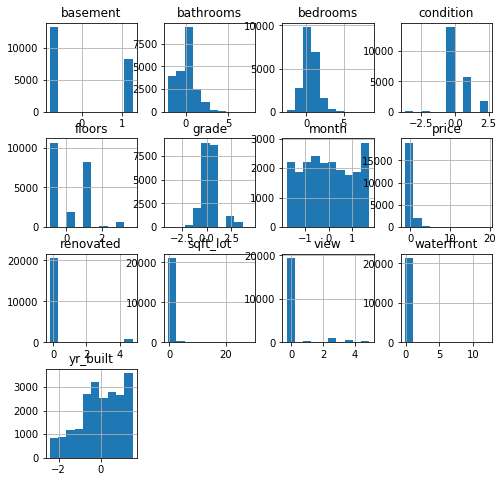

In [1092]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

#normalize the features in our dataset

features_final = df.apply(normalize)
#apply the normalization to ur dataframe

features_final.hist(figsize  = [8, 8]);
#determine the figure size

# LOG TRANSFORMATIONS

In [1093]:
df.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,yr_built,month,basement,renovated
7245,7700000.0,6,8.00,27600,2.5,0.0,3.0,4,13,1910,10,1,1
3910,7060000.0,5,4.50,37325,2.0,1.0,2.0,3,11,1940,6,1,1
9245,6890000.0,6,7.75,31374,2.0,0.0,4.0,3,13,2001,9,1,0
4407,5570000.0,5,5.75,35069,2.0,0.0,0.0,3,13,2001,8,1,1
1446,5350000.0,5,5.00,23985,2.0,0.0,4.0,3,12,2009,4,1,0


In [1094]:
outcome = 'price'
x_cols = ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'condition', 'grade', 'yr_built', 'month']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     3501.
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:25:00   Log-Likelihood:            -2.9742e+05
No. Observations:               21532   AIC:                         5.949e+05
Df Residuals:                   21523   BIC:                         5.949e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    7.84e+06   1.42e+05     55.037      0.000    7.56e+06    8.12e+06
bedrooms   -7875.7516   2178.417     -3.615      0.000   -1.21e+04   -3605.893
bathrooms   1.397e+05   3444.642     40.548      0.000    1.33e+05    1.46e+05
sqft_lot       0.0784      0.042      1.879      0.060      -0.003       0.160
floors      5971.2870   3812.291      1.566      0.117   -1501.086    1.34e+04
condition   2.037e+04   2749.742      7.407      0.000     1.5e+04    2.58e+04
grade       2.024e+05   1940.327    104.318      0.000    1.99e+05    2.06e+05
yr_built   -4658.8051     72.563    -64.204      0.000   -4801.033   -4516.577
month      -2448.8143    528.543     -4.633      0.000   -3484.797   -1412.832
==============================================================================
Omnibus:                    19594.821   Durbin-Watson:                   0.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2100947.501
Skew:                           3.985   Prob(JB):                         0.00
Kurtosis:                      50.731   Cond. No.                     3.69e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.69e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

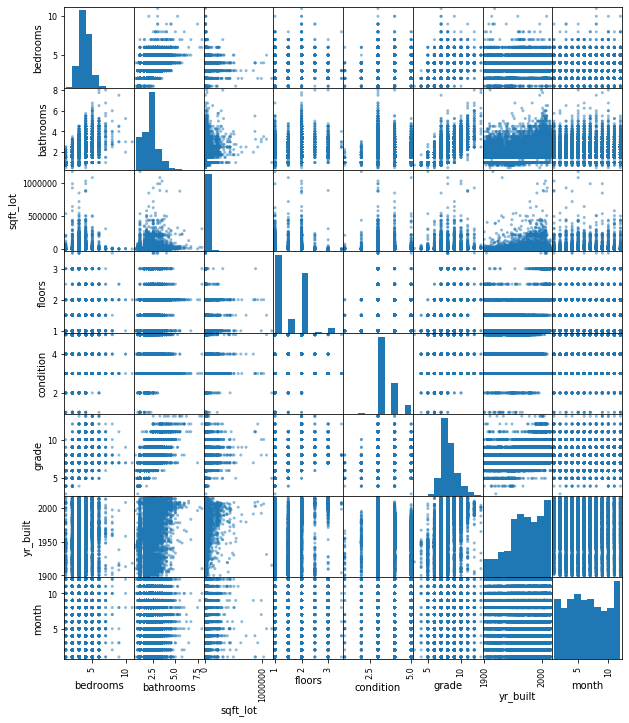

In [1095]:
pd.plotting.scatter_matrix(df[x_cols], figsize=(10,12));

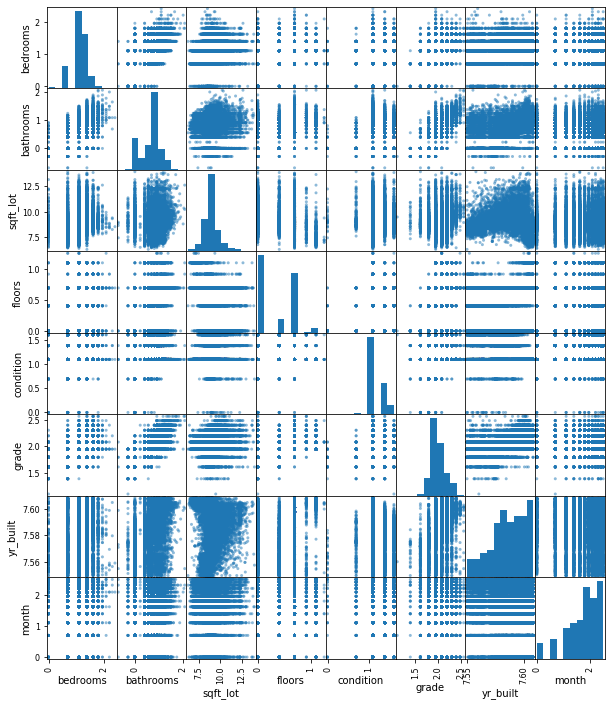

In [1096]:
non_normal = ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'condition', 'grade', 'yr_built', 'month']
for feat in non_normal:
    df[feat] = df[feat].map(lambda x: np.log(x))
pd.plotting.scatter_matrix(df[x_cols], figsize=(10,12));

# CATEGORICAL VARIABLES

In [ ]:
df['waterfront'] = df['waterfront'].astype('category')
df['view'] =df['view'].astype('category')
df['basement'] = df['basement'].astype('category')
df['month'] = df['month'].astype('category')

#set the caterogial variables to the 'category' datatype

In [ ]:
categoricals = ['waterfront', 'view','basement', 'month']
#batch the categorical values into one dataframe

In [ ]:
df.info() #see the data types

In [942]:
waterfront_dummies = pd.get_dummies(df.waterfront, prefix='waterfront').iloc[:,1:]
view_dummies = pd.get_dummies(df.view, prefix='view').iloc[:,1:]
basement_dummies = pd.get_dummies(df.basement, prefix='basement').iloc[:,1:]
month_dummies = pd.get_dummies(df.month, prefix='month').iloc[:,1:]

#set the categorical variables as dummies

## TRAIN / TEST SPLIT

In [943]:
trainset = df.drop('price', axis = 1)
testset = df[['price']]
trainset_train, trainset_test, testset_train, testset_test = train_test_split(trainset, testset, test_size = 0.20, random_state=20)

In [944]:
linreg = LinearRegression()
linreg.fit(trainset_train, testset_train)
yhat_train = linreg.predict(trainset_train)

lm = LinearRegression()
train_mse = mean_squared_error(testset_train, yhat_train)
train_mse

57980021627.773094

## ORDINARY LEAST SQUARES (OLS)

In [945]:
predictors_int = sm.add_constant(trainset_train)
model = sm.OLS(testset_train, predictors_int.astype(float)).fit()
model.summary()

/Users/cruzisiah/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     1853.
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:17:42   Log-Likelihood:            -2.3789e+05
No. Observations:               17225   AIC:                         4.758e+05
Df Residuals:                   17212   BIC:                         4.759e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.443e+07   1.29e+06     42.064      0.000    5.19e+07     5.7e+07
bedrooms    -863.5554   7969.009     -0.108      0.914   -1.65e+04    1.48e+04
bathrooms   1.468e+05   7930.704     18.508      0.000    1.31e+05    1.62e+05
sqft_lot    1.569e+04   2312.064      6.787      0.000    1.12e+04    2.02e+04
floors       7.35e+04   7485.151      9.820      0.000    5.88e+04    8.82e+04
waterfront  6.265e+05   2.38e+04     26.358      0.000     5.8e+05    6.73e+05
view        6.812e+04   2732.018     24.935      0.000    6.28e+04    7.35e+04
condition   5.002e+04    1.1e+04      4.543      0.000    2.84e+04    7.16e+04
grade       1.443e+06   1.77e+04     81.335      0.000    1.41e+06    1.48e+06
yr_built   -7.534e+06   1.71e+05    -44.102      0.000   -7.87e+06    -7.2e+06
month      -2759.1541    591.972     -4.661      0.000   -3919.480   -1598.828
basement    3.658e+04   4449.204      8.222      0.000    2.79e+04    4.53e+04
renovated    1.46e+04   9554.946      1.528      0.127   -4129.577    3.33e+04
==============================================================================
Omnibus:                    15537.471   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1866172.278
Skew:                           3.879   Prob(JB):                         0.00
Kurtosis:                      53.398   Cond. No.                     9.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""